<a href="https://colab.research.google.com/github/Adrish-Sarkar/image_captioning_coco/blob/main/Image_Captioning_COCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning with COCO 2014 Dataset

This notebook implements an Image Captioning model using a CNN-RNN architecture (ResNet Encoder + LSTM Decoder).

## Step 1: Download Data
We will download the COCO 2014 dataset. This includes:
- Training Images (13GB)
- Validation Images (6GB)
- Annotations (241MB)

In [10]:
import os

# Define paths
data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download COCO 2014 Dataset
# Using wget to download directly to Colab environment
!echo "Downloading Training Images..."
!wget -c http://images.cocodataset.org/zips/train2014.zip -O ./data/train2014.zip

!echo "Downloading Validation Images..."
!wget -c http://images.cocodataset.org/zips/val2014.zip -O ./data/val2014.zip

!echo "Downloading Annotations..."
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2014.zip -O ./data/annotations_trainval2014.zip

--2026-01-17 13:02:35--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.129.9, 16.182.104.169, 16.15.179.150, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.129.9|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘./data/train2014.zip’

./data/train2014.zi 100%[===================>]  12.58G  60.6MB/s    in 3m 27s  

2026-01-17 13:06:03 (62.1 MB/s) - ‘./data/train2014.zip’ saved [13510573713/13510573713]

--2026-01-17 13:06:03--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.200.57, 16.15.193.51, 52.216.57.41, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.200.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘./data/val2014.zip’

./data/val2014.zip  100%[===

## Step 2: Unzip Data
Now we unzip the files. This might take a few minutes.

In [11]:
!echo "Unzipping Training Images..."
!unzip -q ./data/train2014.zip -d ./data/

!echo "Unzipping Validation Images..."
!unzip -q ./data/val2014.zip -d ./data/

!echo "Unzipping Annotations..."
!unzip -q ./data/annotations_trainval2014.zip -d ./data/

Unzipping Training Images...
Unzipping Validation Images...
Unzipping Annotations...


In [12]:
# Install pycocotools if not already available (usually pre-installed in Colab)
!pip install pycocotools nltk

In [17]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
from pycocotools.coco import COCO
from collections import Counter

nltk.download('punkt')
nltk.download('punkt_tab')
print("Libraries imported.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Libraries imported.


## Step 3: Vocabulary Builder
We need to convert words into numerical indices. We'll create a `Vocabulary` class to handle this mapping.

In [14]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print(f"[{i+1}/{len(ids)}] Tokenized the captions.", end='\r')

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

## Step 4: Custom Dataset
We need a custom `Dataset` class to load images and corresponding captions.

In [15]:
class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)

def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption)."""
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

## Step 5: Create DataLoader
We define the transforms and initialize the DataLoader.

In [18]:
# Configuration
embed_size = 256
hidden_size = 512
num_layers = 1
batch_size = 128
num_epochs = 5
learning_rate = 0.001
threshold = 4  # Minimum word count to be included in vocab
crop_size = 224

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

# Paths (Assuming structure from Step 1/2)
train_image_path = './data/train2014/'
val_image_path = './data/val2014/'
caption_path = './data/annotations/captions_train2014.json'
val_caption_path = './data/annotations/captions_val2014.json'

print("Building vocabulary... (this may take a minute)")
# Note: In a real run, we would pickle dump/load the vocab to save time.
vocab = build_vocab(json=caption_path, threshold=threshold)
print(f"Vocabulary size: {len(vocab)}")

print("Creating DataLoader...")
train_dataset = CocoDataset(root=train_image_path,
                            json=caption_path,
                            vocab=vocab,
                            transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          collate_fn=collate_fn)
print("DataLoader created.")

Building vocabulary... (this may take a minute)
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
Vocabulary size: 9948
Creating DataLoader...
loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
DataLoader created.


# Step 6: Verification - Visualize a Batch

Caption: a man sitting in a room that has shelves full of books and he has a remote control in his hand .


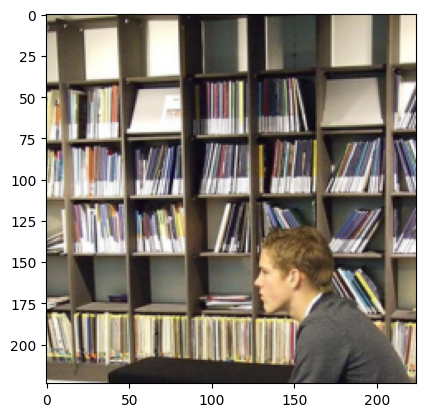

In [20]:
def imshow(img, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.show()

# Get a batch
try:
    images, captions, lengths = next(iter(data_loader))
    image = images[0]
    caption = captions[0]

    # Convert caption to words
    sentence = []
    for token_id in caption:
        token_id = token_id.item()
        if token_id == vocab.word2idx['<end>']:
            break
        if token_id != vocab.word2idx['<start>'] and token_id != vocab.word2idx['<pad>']:
            word = vocab.idx2word[token_id]
            sentence.append(word)

    print("Caption:", ' '.join(sentence))
    imshow(image)
except NameError:
    print("Error: data_loader or vocab not defined. Make sure you ran Step 6!")